- If the organization inside the testing dataset folder is the same as in the training 'dataset' folder, it is enough to update only path_dataset, path_output_folder and img number

In [97]:
from PIL import Image, ImageDraw
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

path_dataset = "/content/drive/MyDrive/temp/Task 2/dataset/"

path_human_parsing = f"{path_dataset}human_parsing/"
path_images = f"{path_dataset}image/"
path_pose_imgs = f"{path_dataset}pose_img/"
path_pose_jsons = f"{path_dataset}pose_json/"

path_output_folder = "/content/drive/MyDrive/temp/Data_Engineer_Bekbol_A/Task2_results/"

In [98]:
# functions to be used

# gets xy coordinates of given keypoint
def get_xy(keypoints, point):
  return keypoints[point*3:point*3+2]

# gets color of given xy
def get_color_of_xy(image, xy):
  color = image[int(xy[1]), int(xy[0])]
  return color

# main function
def shade_lower_part(parsed_img, image, keypoints):
  # Color to use for shading. Black is used.
  color_shading = (0, 0, 0)

  # get coordinates of left shoes by color
  l_shoes_coord = np.column_stack(np.where(np.all(parsed_img == map_bodypart_color['left_shoes'], axis=-1)))
  # get coordinates of right shoes by color
  r_shoes_coord = np.column_stack(np.where(np.all(parsed_img == map_bodypart_color['right_shoes'], axis=-1)))

  points = [8,10,13,11,14]
  for point in points:
    # get xy of a point
    xy = get_xy(keypoints, point)
    # get its color in parsed image
    color_to_find = get_color_of_xy(parsed_img, xy)
    # get all coordinates which matches with the color
    coordinates = np.column_stack(np.where(np.all(parsed_img == color_to_find, axis=-1)))

    # remove if left shoes are in coordinates
    filtered_coordinates = np.setdiff1d(coordinates.view([('', coordinates.dtype)] * coordinates.shape[1]), l_shoes_coord.view([('', l_shoes_coord.dtype)] * l_shoes_coord.shape[1]))
    coordinates = filtered_coordinates.view(coordinates.dtype).reshape(-1, coordinates.shape[1])

    # remove if right shoes are in coordinates
    filtered_coordinates = np.setdiff1d(coordinates.view([('', coordinates.dtype)] * coordinates.shape[1]), r_shoes_coord.view([('', r_shoes_coord.dtype)] * r_shoes_coord.shape[1]))
    coordinates = filtered_coordinates.view(coordinates.dtype).reshape(-1, coordinates.shape[1])

    # shade the image
    for coord in coordinates:
      x, y = coord[1], coord[0]
      image[y, x] = color_shading

  # shade socks
  socks_coord = np.column_stack(np.where(np.all(parsed_img == map_bodypart_color['socks'], axis=-1))) # coordinates of socks
  for coord in socks_coord:
    x, y = coord[1], coord[0]
    image[y, x] = color_shading


  # shade area between legs
  empty_area = [get_xy(keypoints, point) for point in [9, 12, 14, 11]]
  pts = np.array(empty_area, dtype=np.int32)
  pts = pts.reshape((-1, 1, 2))
  cv2.fillPoly(image, [pts], color_shading)

  return image

In [103]:
# generate paths from image number
img_number = "48378"
path_human_parsing_img = f"{path_human_parsing}{img_number}_00.png"
path_images_img = f"{path_images}{img_number}_00.jpg"
path_pose_imgs_img = f"{path_pose_imgs}{img_number}_00_rendered.png"
path_pose_jsons_img = f"{path_pose_jsons}{img_number}_00_keypoints.json"

# Open the JSON file and get keypoints
with open(path_pose_jsons_img, 'r') as json_file:
    data = json.load(json_file)
keypoints = data['people'][0]['pose_keypoints_2d']

# dictionary matching parts with colors in parsed images
map_bodypart_color = {'right_shoes': (0, 192, 128), 'left_shoes': (0, 192,   0), 'right_leg': (0,  64, 128), 'left_leg': (0, 64,  0), 'socks': (0,   0,   64)}

parsed_img = cv2.imread(path_human_parsing_img)
image = cv2.imread(path_images_img)
image = shade_lower_part(parsed_img, image, keypoints)
cv2.imwrite(f"{path_output_folder}{img_number}_00.jpg", image)

True

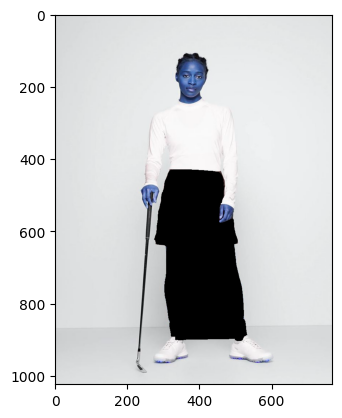

In [104]:
# show the image
plt.imshow(image)